In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))

from UKMovementSensing import hsmm

import pandas as pd
import numpy as np

In [21]:
execfile('config.py')

## Load the data

In [6]:
filenames = os.listdir(subset_path)
filenames = [fn for fn in filenames if os.path.isfile(os.path.join(subset_path,fn))]
datasets = [pd.read_csv(os.path.join(subset_path,fn)) for fn in filenames]
print(len(datasets))

11


In [7]:
for i in range(len(datasets)):
    datasets[i] = datasets[i].set_index('timestamp')
    datasets[i].index = pd.to_datetime(datasets[i].index) 

In [9]:
# Take one example datset and have a look
example_index = 2
example_data = datasets[example_index]

example_data.head()

,acceleration,EN,anglex,angley,anglez,roll_med_acc_x,roll_med_acc_y,roll_med_acc_z,dev_roll_med_acc_x,dev_roll_med_acc_y,dev_roll_med_acc_z,invalid,filename,Slot,act,act_label,start_time,subset
timestamp,,,,,,,,,,,,,,,,,,
2015-03-05 04:00:00,0.003365,0.996340,-65.315964,12.839137,-20.705795,-0.904853,0.221299,-0.352103,-0.001102,0.001002,0.003621,0,__016580_2015-03-12 09-09-15.bin_day1,1,1.0,Sleeping and resting (including sick in bed),2015-03-05 04:00:00+00:00,0
2015-03-05 04:00:05,0.003278,0.998538,-62.658269,13.348475,-23.393921,-0.886729,0.230470,-0.396355,0.002263,0.001669,-0.004457,0,__016580_2015-03-12 09-09-15.bin_day1,1,1.0,Sleeping and resting (including sick in bed),2015-03-05 04:00:00+00:00,0
2015-03-05 04:00:10,0.002431,0.998578,-62.733459,13.280806,-23.351338,-0.887516,0.229370,-0.395758,-0.000157,-0.000412,-0.000040,0,__016580_2015-03-12 09-09-15.bin_day1,1,1.0,Sleeping and resting (including sick in bed),2015-03-05 04:00:00+00:00,0
2015-03-05 04:00:15,0.001929,0.998130,-62.790675,13.155759,-23.364066,-0.887516,0.227132,-0.395758,0.000197,0.000648,-0.000378,0,__016580_2015-03-12 09-09-15.bin_day1,1,1.0,Sleeping and resting (including sick in bed),2015-03-05 04:00:00+00:00,0
2015-03-05 04:00:20,0.002238,0.998390,-62.790675,13.155759,-23.364066,-0.887516,0.227132,-0.395758,0.000000,0.000668,-0.000577,0,__016580_2015-03-12 09-09-15.bin_day1,1,1.0,Sleeping and resting (including sick in bed),2015-03-05 04:00:00+00:00,0


## Prepare data for HSMM

In [13]:
X_list = [d[column_names].as_matrix() for d in datasets]

## Train HSMM

0
Resampled 11 sequences in 28.2 seconds
('Log likelihood: ', -2466240.7903407044)
1
Resampled 11 sequences in 25.7 seconds
('Log likelihood: ', -2288106.8033753447)


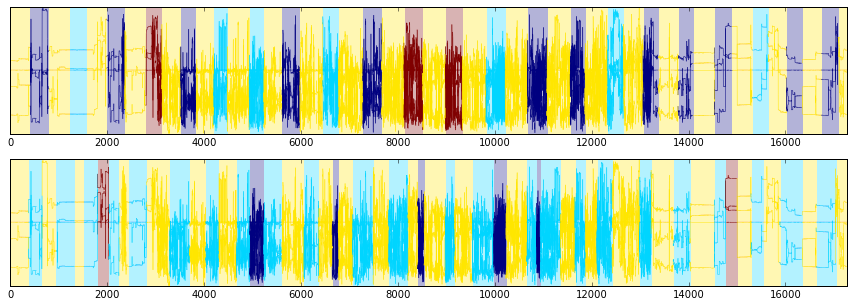

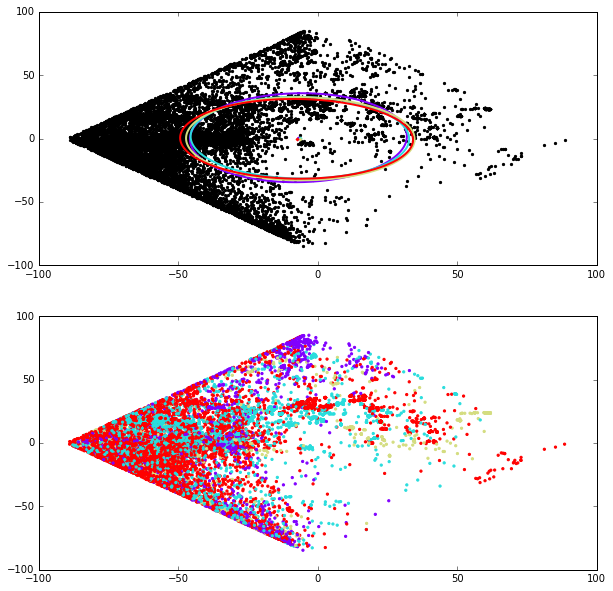

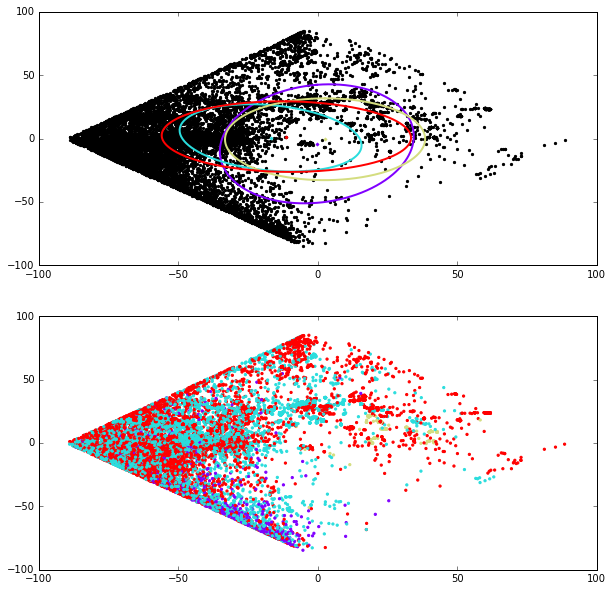

In [18]:
model, model_dist = hsmm.train_hsmm(X_list, Nmax=Nmax, nr_resamples=nr_resamples, trunc=truncate, visualize=True, example_index=example_index)

## Save the model

In [20]:
import pickle
#TODO: the model object also contains the data so this is not very efficient
if not os.path.exists(model_path):
        os.makedirs(model_path)
with open(os.path.join(model_path, 'model_{}states.pkl'.format(Nmax)), 'wb') as f:
    pickle.dump(model, file=f)

## Save the data with the states

In [23]:
if not os.path.exists(states_path):
        os.makedirs(states_path)
for i, dat in enumerate(datasets):
    dat['state'] = model.stateseqs[i]
    fn = str(str(dat['subset'][0]) + dat['filename'][0])+'.csv'
    dat.to_csv(os.path.join(states_path, fn))